오토 인코더로 망가진 이미지 복원하기 

- 앞의 오토 인코더와는 큰 차이가 없으며, 학습할 때 입력에 잡음을 더하는 방식으로 복원 능력을 강화한 것이 핵심이다. 
- 이번 예제는 학습 시 모델에 들어갈 입력에 add_noise() 함수를 더해 이미지에 무작위 잡음을 더하면 된다. 

In [1]:
#오토 인코더로 이미지의 특징 추출하기 
#FashionMNIST데이터셋 이용 및 잠재변수 시각화

#라이브러리 로드
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

#하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print('Using Device:', DEVICE)

#학습 데이터셋 로드 
trainset = datasets.FashionMNIST( root = './.data/',
                                train = True, 
                                download = True, 
                                transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader( dataset = trainset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True, 
                                           num_workers = 2)



Using Device: cpu


In [2]:
#오토 인코더 모듈 정의
#인코더와 디코더로 나뉜 두 부분을 시퀀셜을 이용하여 두 모듈로 묶어준다.

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #인코더 데이터 픽셀수인 28*28(784)차원으로 시작하여 최종적으로 3개의 차원 출력(3차원시각화위해)
        self.encoder = nn.Sequential(nn.Linear(28*28, 128),
                                    nn.ReLU(),
                                    nn.Linear(128,64),
                                    nn.ReLU(),
                                    nn.Linear(64,12),
                                    nn.ReLU(),
                                    nn.Linear(12,3))
        #디코더는 3차원 잠재변수를 받아 다시 784차원 이미지로 복원( 차이는 마지막 출력값을 0과 1사이로 만들어주는 시그모이드 함수 추가)
        self.decoder = nn.Sequential(nn.Linear(3,12),
                                    nn.ReLU(),
                                    nn.Linear(12,64),
                                    nn.ReLU(),
                                    nn.Linear(64,128),
                                    nn.ReLU(),
                                    nn.Linear(128,28*28),
                                    nn.Sigmoid())
        
        #데이터의 흐름
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
        

In [3]:
#모델과 최적화 함수 객채 불러오기 
autoencoder = Autoencoder().to(DEVICE)
#Adam()은 SGD의 변형 함수이며 학습 중인 기울기를 참고하여 학습속도를 자동으로 변화시킨다. 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)
#디코더에서 나온값과 원본의 차이(오차) 계산을 위해 MSE 함수 이용
criterion = nn.MSELoss()

In [7]:
def add_noise(img):
    noise = torch.randn(img.size())*0.2 #잡음의 강도는 0.2
    noisy_img = img+noise
    return noisy_img

In [15]:
#학습 입력 X와 레이블y모두 원본이미지 x
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x) #입력에 노이즈 더하기 
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        #디코디드에서 y를 빼고 제곱한 값의 평균을 구해 오차 구한다. 
        loss = criterion(decoded,y)
        #기존의 남아있는 기울기 정보 초기화
        optimizer.zero_grad()
        #함수 기울기를 구하고 최적화 진행
        loss.backward()
        optimizer.step()
        
        #학습 중 변화하는 평균 오찻값을 관찰하고, 저장하는 avg_loss변수를 만들고 반복마다 각 배치의 오찻값을 더한 후, 
        #마지막에 반복횟수만큼 나누어 평균 구함
        avg_loss += loss.item()
        
    return avg_loss/len(train_loader)



In [16]:
#이번 예제는 시각화를 생략하고 학습과정 확인
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print('EPOCHO {}  LOSS  {} '.format(epoch, loss))


EPOCHO 1  LOSS  0.07377702107768196 
EPOCHO 2  LOSS  0.06534329741827842 
EPOCHO 3  LOSS  0.06394499446600993 
EPOCHO 4  LOSS  0.06339804828564115 
EPOCHO 5  LOSS  0.06295301732636972 
EPOCHO 6  LOSS  0.0627231661127066 
EPOCHO 7  LOSS  0.06247991882264614 
EPOCHO 8  LOSS  0.06234194651277843 
EPOCHO 9  LOSS  0.06221951043872691 
EPOCHO 10  LOSS  0.06210339431172368 


평균 오찻값이 확연히 떨어지는 것을 확인 가능

In [19]:
#잡음 제거 시각화 
#본적이 없는 테스트 이미지를 활용해 검증
testset = datasets.FashionMNIST( root = './.data/',
                               train = False,
                               download = True, 
                               transform = transforms.ToTensor())

#테스트 셋 0번째 이미지 한장을 가져와 모델의 입력으로 이용하게 차원과 값의 범위를 수정(0~255(2차원) -> 0~1(1차원))
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255

#테스트 이미지를 학습에 이용한 노이즈 함수로 잡음을 더해주고 모델에 통과 (인코딩 된 것은 무시하고 복원 이미지만 확인)
# '_'는 특정값을 무시하는 용도
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

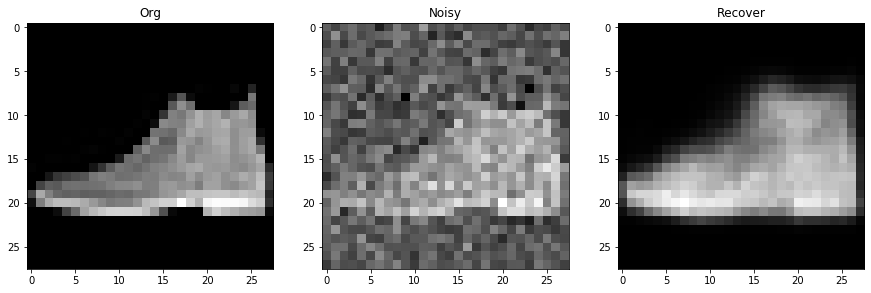

In [21]:
#시각화를 위해 틀을 만들고, 원본 / 오염/ 복원 이미지를 넘파이 행렬로 변환(시각화를 위해 )

f, a = plt.subplots(1,3, figsize = (15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(),(28,28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(),(28,28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(),(28,28))

#원본
a[0].set_title('Org')
a[0].imshow(original_img, cmap='gray')

#오염
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

#복원

a[2].set_title('Recover')
a[2].imshow(recovered_img, cmap='gray')

복원성능이 어느정도 나오지만, 특징 추출 과정에서 덜 중요한 특징들은 버려질 수 있다.